In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, roc_auc_score, precision_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

pd.set_option('display.max_rows', 250)

In [2]:
df_ml_conso_validation = pd.read_csv('../../datasets/3_ml_patients_consolidation/df_ml_conso_validation.csv')
df_ml_conso_validation = df_ml_conso_validation.iloc[:,2:]
df_ml_conso_validation.head()

,qSQI_score,cSQI_score,sSQI_score,kSQI_score,pSQI_score,basSQI_score,classification
0,0.67,0.54,5.15,35.58,0.48,0.93,1
1,0.92,0.62,3.01,15.50,0.53,0.85,1
2,0.91,0.66,3.89,22.35,0.57,0.87,1
3,0.55,0.57,0.09,3.30,0.47,0.91,0
4,0.76,0.59,0.54,-0.44,0.51,0.72,0


In [3]:
df_ml_conso_balanced = pd.read_csv('../../datasets/3_ml_patients_consolidation/df_ml_conso_balanced.csv')
df_ml_conso_balanced = df_ml_conso_balanced.iloc[:,2:]
df_ml_conso_balanced.head()

,qSQI_score,cSQI_score,sSQI_score,kSQI_score,pSQI_score,basSQI_score,classification
0,0.64,0.57,2.71,9.90,0.52,0.95,0
1,0.72,0.62,3.55,15.64,0.51,0.96,0
2,0.95,0.57,2.59,11.31,0.51,0.88,0
3,0.85,0.59,2.97,10.79,0.51,0.94,0
4,0.92,0.64,3.93,17.05,0.53,0.92,0


In [4]:
def make_performance_report(model, X_train, y_train):

    print('\nPerformance report :\n')
    # Feedback of the best model
    print('Best parameters:',model.best_params_)
    print('Score of best estimator on train:',model.best_estimator_.score(X_train, y_train))

    # Creation of the predictions of y_train & y_test

    y_train_pred = model.predict(X_train)

    # Output the accuracy and f1 score for the model
    print()
    print("Accuracy on train set :", accuracy_score(y_train, y_train_pred))
    print()

    print()
    print("f1-score on traina set :", f1_score(y_train, y_train_pred))
    print()

    print()
    print("Recall on train set :", recall_score(y_train, y_train_pred))
    print()

    print()
    print("Precision on train set :", precision_score(y_train, y_train_pred))
    print()

    print()
    print("ROC_AUC_score on train set :", roc_auc_score(y_train, y_train_pred))
    print()

    # Plot non-normalized confusion matrix
    titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(model, X_train, y_train,
                                    display_labels=[0,1],
                                    cmap=plt.cm.Blues,
                                    normalize=normalize)
        disp.ax_.set_title(title)

    plt.show()

# I - Preprocessing

In [5]:
df = df_ml_conso_balanced

# Declaration of target and features_list

target_variable = 'classification'
features_list = df.columns.drop(target_variable)

X = df.loc[:, features_list]
y = df.loc[:, target_variable]

# Distinction of categorical features
# (string values, columns index for numpy use)

categorical_features_str = (X.select_dtypes(include=['object']).columns)
categorical_features = [X.columns.get_loc(i) for i in categorical_features_str]

print('categorical columns:',categorical_features)

# Distinction of numeric features 

numeric_features_str = X.columns.drop(categorical_features_str)
numeric_features = [X.columns.get_loc(i) for i in numeric_features_str]

print('numeric columns:',numeric_features)


# Convertion of pandas DataFrames to numpy arrays before using scikit-learn

X_train = X.values
y_train = y.values

print('Proportion of class 1 in y_train: ', np.mean(y_train))

# Declaration of the categorical and numeric transfomers

categorical_transformer = OneHotEncoder(drop='first')
numeric_transformer = StandardScaler()

# Declaration of the feature encoder

feature_encoder = ColumnTransformer(
transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
]
)

# Fit of the encoder on X_train and transform of X_train

# Fit on X

feature_encoder.fit(X_train)

print('Shape before feature encoder:', X_train.shape)
X_train = feature_encoder.transform(X_train)
print('Shape after feature encoder:', X_train.shape)

categorical columns: []
numeric columns: [0, 1, 2, 3, 4, 5]
Proportion of class 1 in y_train:  0.5
Shape before feature encoder: (6324, 6)
Shape after feature encoder: (6324, 6)


In [6]:
# Preprocessing for validation dataset
df_val = df_ml_conso_validation

X_val = df_val.loc[:, features_list]
y_val = df_val.loc[:, target_variable]

X_val = feature_encoder.transform(X_val)

# II - Logistic Regression

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  40 | elapsed:    0.9s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  27 out of  40 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  36 out of  40 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.0s finished
GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'class_weight': [True, False],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg']},
             scoring='f1', verbose=5)

Performance report :

Best parameters: {'class_weight': True, 'penalty': 'l2', 'solver': 'newton-cg'}
Score of best estimator on train: 0.8078747628083491

Accuracy on train set : 0.8078747628083491


f1-score on traina set : 0.8108949416342413


Recall on train set : 

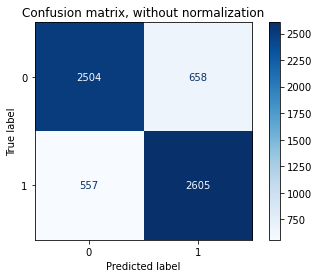

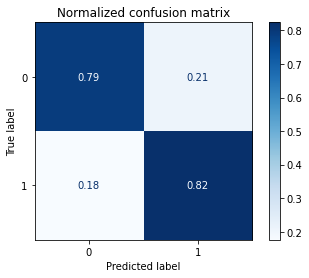

In [7]:
# Declaration of algorithm and parameters for gridsearch

algo = LogisticRegression()
params = {'class_weight' : [True, False],
          'solver' : ['newton-cg',],
          'penalty': ['l1', 'l2', 'elasticnet', 'none']
         }
grid_search_log = GridSearchCV(estimator=algo, param_grid= params, scoring='f1', cv = 5,verbose=5,n_jobs=-1)

# Fitting on train datas

grid_search_log.fit(X_train, y_train)
print(grid_search_log)
make_performance_report(grid_search_log , X_train, y_train)


Performance report :

Best parameters: {'class_weight': True, 'penalty': 'l2', 'solver': 'newton-cg'}
Score of best estimator on train: 0.8131100266193434

Accuracy on train set : 0.8131100266193434


f1-score on traina set : 0.7576585646483531


Recall on train set : 0.8238974038160776


Precision on train set : 0.7012779552715654


ROC_AUC_score on train set : 0.8155403843276985



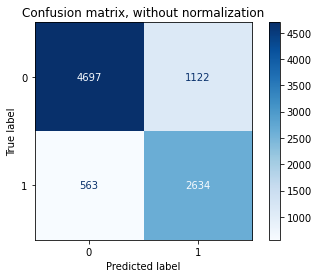

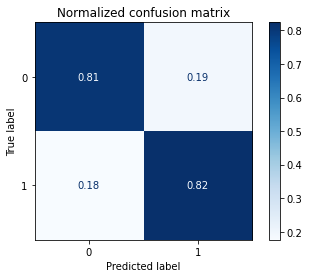

In [8]:
# Performance report on validation Dataset

make_performance_report(grid_search_log , X_val, y_val)

# III - ML - Random Forest Classifier

In [9]:
# Declaration of algorithm and parameters for gridsearch

algo = RandomForestClassifier()
params = {'class_weight' : [None, 'balanced'],
          'min_samples_leaf' : np.arange(6,12,1),
         'max_depth' :  np.arange(6,12,1),
         'max_features' : np.arange(6,12,1),
         'n_estimators' : np.arange(6,12,1),
         'criterion' : ['gini', 'entropy']
         }

RanClassF1 =  GridSearchCV(estimator=algo, param_grid= params, scoring='f1', cv = 5,verbose=5,n_jobs=-1)

# grid_search_RFC_list = [RanClassRecall, RanClassAcc, RanClassPrecision, RanClassF1, RanClassRocAuc]

grid_search_RFC_list = [RanClassF1]

# Fitting on train datas

for grid_search in grid_search_RFC_list:
    grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 5184 candidates, totalling 25920 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1184 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 3776 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 6944 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 10688 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 13312 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 15760 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 18496 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 21520 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 24832 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 25920 out of 25920 | elapsed:   54.7s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 6,  7,  8,  9, 10, 11]),
                         'max_features': array([ 6,  7,  8,  9, 10, 11]),
                         'min_samples_leaf': array([ 6,  7,  8,  9, 10, 11]),
                         'n_estimators': array([ 6,  7,  8,  9, 10, 11])},
             scoring='f1', verbose=5)

Performance report :

Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 6, 'min_samples_leaf': 11, 'n_estimators': 11}
Score of best estimator on train: 0.9032258064516129

Accuracy on train set : 0.9032258064516129


f1-score on traina set : 0.9058751153491233


Recall on train set : 0.9313725490196079


Precision on train set : 0.8817365269461078


ROC_AUC_score on train set : 0.903225806451613



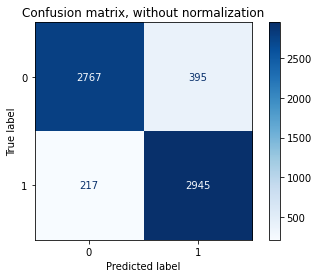

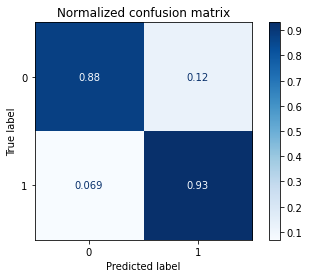

In [10]:
for grid_search in grid_search_RFC_list:
    print(grid_search)
    make_performance_report(grid_search , X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 6,  7,  8,  9, 10, 11]),
                         'max_features': array([ 6,  7,  8,  9, 10, 11]),
                         'min_samples_leaf': array([ 6,  7,  8,  9, 10, 11]),
                         'n_estimators': array([ 6,  7,  8,  9, 10, 11])},
             scoring='f1', verbose=5)

Performance report :

Best parameters: {'class_weight': True, 'penalty': 'l2', 'solver': 'newton-cg'}
Score of best estimator on train: 0.8131100266193434

Accuracy on train set : 0.8131100266193434


f1-score on traina set : 0.7576585646483531


Recall on train set : 0.8238974038160776


Precision on train set : 0.7012779552715654


ROC_AUC_score on train set : 0.8155403843276985



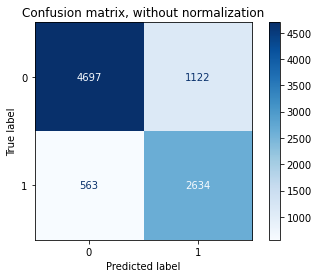

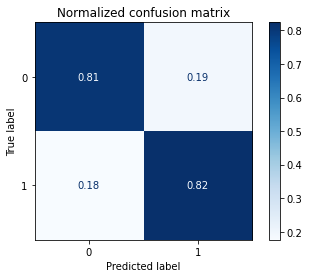

In [11]:
# Performance report on validation Dataset
for grid_search in grid_search_RFC_list:
    print(grid_search)
    make_performance_report(grid_search_log , X_val, y_val)


# IV - ML - XGBoost

In [12]:
# Declaration of algorithm and parameters for gridsearch

algo = XGBClassifier()
params = {'min_samples_leaf' : np.arange(6,12,1),
         'max_depth' :  np.arange(6,12,1),
         'max_features' : np.arange(6,12,1),
         'n_estimators' : np.arange(6,12,1),
         'criterion' : ['gini', 'entropy']
         }

params = {'class_weight': [None], 'criterion': ['entropy'], 'max_depth': [11], 'max_features': [6], 'min_samples_leaf': [8], 'n_estimators': [11],
'learning_rate': [0.20, 0.25, 0.30, 0.35, 0.40 ], 'gamma':[ 0.0, 0.1, 0.2]}

XGBClassF1 =  GridSearchCV(estimator=algo, param_grid= params, scoring='f1', cv = 5,verbose=5,n_jobs=-1)

# grid_search_list = [RanClassRecall, RanClassAcc, RanClassPrecision, RanClassF1, RanClassRocAuc]

grid_search_XGB_list = [XGBClassF1]

# Fitting on train datas

for grid_search in grid_search_XGB_list:
    grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:  1.0min remaining:   15.5s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.2min finished
[18:26:21] WARNING: ../src/learner.cc:541: 
Parameters: { criterion, max_features, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:26:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
  

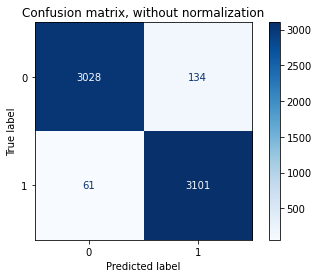

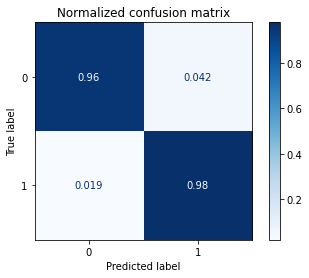

In [13]:
for grid_search in grid_search_XGB_list:
    print(grid_search)
    make_performance_report(grid_search , X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
  

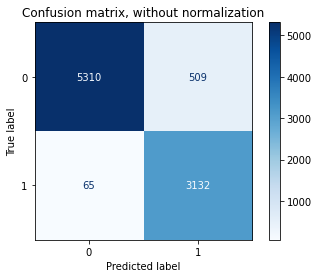

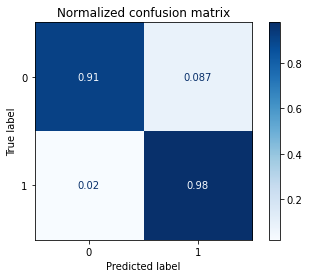

In [14]:
for grid_search in grid_search_XGB_list:
    print(grid_search)
    make_performance_report(grid_search , X_val, y_val)

# V - Export of models

In [15]:
# dump feature encoder
dump(feature_encoder, '../../ecg_qc/ml/data_encoder/data_encoder.joblib')

# dump RandomForestClassifier model
dump(grid_search_RFC_list[0].best_estimator_, '../../ecg_qc/ml/models/rfc.joblib')

# dump XGBoostClassifier model
dump(grid_search_XGB_list[0].best_estimator_, '../../ecg_qc/ml/models/xgb.joblib')

['../../ecg_qc/ml/models/xgb.joblib']